# Redistribute Dataset split
Currente is bad 33 files inside of validation folder. There are in total 2926 images which needs to be redistributed into a 70:15:15 **random** split. Currently there are 2521 images in the train folder, 33 in the validation folder, and 372 in the test folder.

*Note: the shuffling only happened once. Once code is re-executed, the same images will be present in the corresponding folder!*

In [29]:
import os
import random
import shutil

# Seed for reproducibility
random.seed(42)

# Function to clear the contents of a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Deletes the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreates the directory

# Directories
base_dir = "./Rock-Paper-Scissors"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Temporary directory to consolidate all images
temp_dir = os.path.join(base_dir, "all_images")
clear_directory(temp_dir)

# Target directories for the final split
new_train_dir = os.path.join(base_dir, "resplit_train")
new_val_dir = os.path.join(base_dir, "resplit_validation")
new_test_dir = os.path.join(base_dir, "resplit_test")

# Clear existing directories
clear_directory(new_train_dir)
clear_directory(new_val_dir)
clear_directory(new_test_dir)

# Step 1: Consolidate all images into one folder
def consolidate_images(src_dir, temp_dir, class_name=None):
    for root, _, files in os.walk(src_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                src_path = os.path.join(root, file)
                if class_name:  # Add class name as prefix for validation images
                    dst_path = os.path.join(temp_dir, f"{class_name}_{file}")
                else:
                    dst_path = os.path.join(temp_dir, file)
                shutil.copy(src_path, dst_path)

# Consolidate images from train, test, and validation folders
for class_name in ["scissors", "paper", "rock"]:
    consolidate_images(os.path.join(train_dir, class_name), temp_dir, class_name)
    consolidate_images(os.path.join(test_dir, class_name), temp_dir, class_name)
consolidate_images(val_dir, temp_dir)  # Validation images are directly in this folder

# Step 2: Split images into train, validation, and test
all_images = os.listdir(temp_dir)
random.shuffle(all_images)

# Calculate exact split sizes
total_images = len(all_images)
train_size = int(total_images * 0.7)
remaining = total_images - train_size
val_size = remaining // 2
test_size = remaining - val_size

# Check and print sizes
print(f"Training size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

# Split the images
train_images = all_images[:train_size]
val_images = all_images[train_size:train_size + val_size]
test_images = all_images[train_size + val_size:]

# Step 3: Move images to the new directories
def move_images(image_list, target_dir, no_subfolders=False):
    for img in image_list:
        src_path = os.path.join(temp_dir, img)
        if "_" in img and not no_subfolders:  # For train and test, keep subfolders
            class_name = img.split("_")[0]
            class_dir = os.path.join(target_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            shutil.move(src_path, os.path.join(class_dir, img))
        else:  # For validation, move images directly
            shutil.move(src_path, os.path.join(target_dir, img))

# Move images to their respective folders
move_images(train_images, new_train_dir)
move_images(val_images, new_val_dir, no_subfolders=True)  # No subfolders for validation
move_images(test_images, new_test_dir)

# Remove temporary directory after use
shutil.rmtree(temp_dir)

print("Resplit completed!")


Training size: 2048, Validation size: 439, Test size: 439
Resplit completed!


Validate **new split in resplit_XXX directories**

In [ ]:
def count_images_in_split(target_dir):
    for split in ["resplit_train", "resplit_validation", "resplit_test"]:
        split_dir = os.path.join(base_dir, split)
        total_images = sum([len(files) for _, _, files in os.walk(split_dir)])
        print(f"{split.capitalize()} Set: {total_images} images")

count_images_in_split(base_dir)

# Machine learning model

## 1. NN implementaton
In this implementation a NN model will be created, fitted and optimized to classify the images

### Preprocessing
Fetch data and create test, validation and training datasets

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt


class_names = ["paper", "rock", "scissors"]

def fetch_val_dataset(class_names, val_dir):
    ''' 
    Fetch images from specified dir and process to grayscale and appropriate dims
    '''

    class_to_index = {class_name: i for i, class_name in enumerate(class_names)} # provide index for each label.
    
    # process images and store into array with corresponding labels
    images = []
    labels = []
    
    for file_name in os.listdir(val_dir):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):
            # extract label from filename.
            label = next((name for name in class_names if name in file_name.lower()), None) 
            if label is not None:
                # Construct the full path to the image
                file_path = os.path.join(val_dir, file_name)
    
                # Process image, i.e. graysale, resize and normalize!!
                with Image.open(file_path).convert("L") as img: #note: L grayscale image
                    img = img.resize((300,300))
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
    
            # append label's index.
            labels.append(class_to_index[label])

    # convert ot numpy arrays
    X = np.array(images, dtype="float32") # shape = each sample with 60x60 array
    Y = np.array(labels, dtype="int32") # shape is num of samples, 1

    # add channel dimension to images (for grayscale input)
    X = np.expand_dims(X, axis=-1)

    return X, Y

def visualize_tf_dataset(dataset, class_names, title="Dataset Samples"):
    '''
    Visualize samples of tf_dataset dtype
    '''
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(9):  # Show 9 samples
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")  # Grayscale images
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

def plot_numpy_dataset(X, Y, class_names, title="Validation Dataset Samples"):
    '''
    Visualize samples of Numpy array dtype
    '''
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X[i].squeeze(), cmap="gray")
        plt.title(class_names[Y[i]])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()



# Set paths for train, validation, and test directories
train_dir = "./Rock-Paper-Scissors/resplit_train"
val_dir = "./Rock-Paper-Scissors/resplit_validation"
test_dir = "./Rock-Paper-Scissors/resplit_test"

# Load datasets
'''
    creates pixels in grayscale 60x60 mode with a 32 batch size. 
    and note: labels => automatically inferred.
'''

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(300, 300),  
    color_mode="grayscale",  
    batch_size=64           
)

X_val, Y_val = fetch_val_dataset(class_names, val_dir)
print(f"Validation images shape: {X_val.shape}")  # Example: (33, 300, 300, 1)
print(f"Validation labels shape: {Y_val.shape}")  # Example: (33,)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(300, 300),
    color_mode="grayscale",  
    batch_size=64
)

# Rescale pixels
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


# Shuffle and prefetch for efficiency
AUTOTUNE = tf.data.AUTOTUNE # prefetching => used to make loading data and preprocessing async to model training
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)



2024-12-10 14:03:28.915817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 14:03:28.963531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2024 files belonging to 3 classes.
Validation images shape: (439, 300, 300, 1)
Validation labels shape: (439,)
Found 432 files belonging to 3 classes.


Visualize samples of each dataset to check correctness of preprocessing


In [ ]:
#check whether preprocessing is succesfull by checking a couple of samples
visualize_tf_dataset(train_dataset, class_names, title="Training Dataset Samples")
visualize_tf_dataset(test_dataset, class_names, title="Test Dataset Samples")
plot_numpy_dataset(X_val, Y_val, class_names, title="Validation Dataset Samples")

### NN model implementation
Implement NN model, configure it with hyperparams, loss function to use and the optimizer.
note: this is the fully connected NN (FCNN) model which won't be as accurate as a CNN model!

In [24]:
model = Sequential([
    layers.Flatten(input_shape=(300, 300, 1)),  # Input layer to flatten the image
    layers.Dense(128, activation='relu', name="L1"),  # Increased neurons
    layers.Dense(64, activation='relu', name="L2"),
    layers.Dense(64, activation='relu', name="L3"),
    layers.Dense(3, activation='softmax', name="output")  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Standard learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1 (Dense)                      │ (None, 128)            │    11,520,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,532,739 (43.99 MB)

 Trainable params: 11,532,739 (43.99 MB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,  # Use the validation dataset
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3413 - loss: 2.6099 - val_accuracy: 0.4715 - val_loss: 0.9326
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4663 - loss: 0.9956 - val_accuracy: 0.5877 - val_loss: 0.8062
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7110 - loss: 0.7665 - val_accuracy: 0.7973 - val_loss: 0.6668
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8012 - loss: 0.6465 - val_accuracy: 0.7790 - val_loss: 0.6141
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8123 - loss: 0.5837 - val_accuracy: 0.8542 - val_loss: 0.5328
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7599 - loss: 0.6056 - val_accuracy: 0.8018 - val_loss: 0.5357
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8382 - loss: 0.5018 - val_accuracy: 0.8633 - val_loss: 0.4641
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8768 - loss: 0.4409 - val_accuracy: 0.

### Predict with model and visualize training and validation results

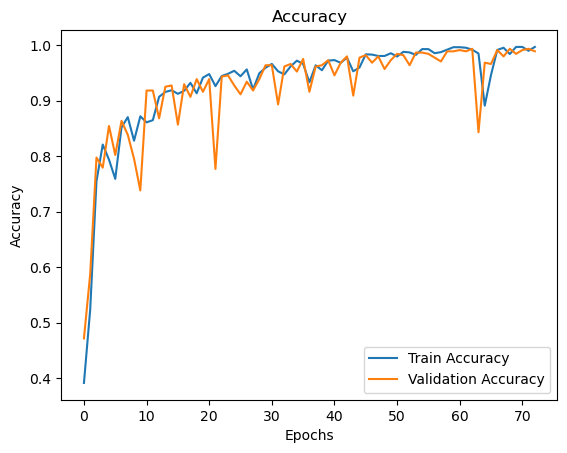

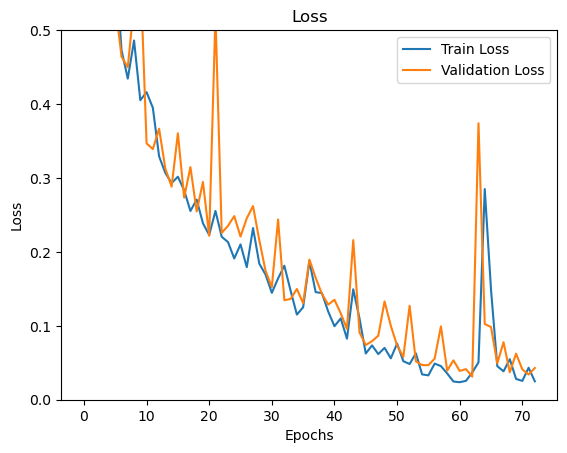

In [26]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.5)  # Replace ymin and ymax with your desired limits
plt.legend()
plt.show()

### Evaluate model with test dataset

In [28]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9953 - loss: 0.0247
Test Accuracy: 0.9953703880310059


In [27]:
# Evaluate one batch of training data
for X_batch, Y_batch in train_dataset.take(1):
    train_loss, train_acc = model.evaluate(X_batch, Y_batch, verbose=0)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")

# Evaluate the validation data
val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")



Train Loss: 0.01572689600288868, Train Accuracy: 1.0


2024-12-10 15:27:27.988313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 0.031291134655475616, Validation Accuracy: 0.9931662678718567
